Source: http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

**Forcasting energy consumption by household** 

***Load the dataset and calculate the active energy***

In [2]:
library(dplyr)

data <-read.csv("household_power_consumption.csv", stringsAsFactors = FALSE) 


Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [3]:
head(data)

Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17
16/12/2006,17:25:00,5.36,0.436,233.63,23,0,1,16
16/12/2006,17:26:00,5.374,0.498,233.29,23,0,2,17
16/12/2006,17:27:00,5.388,0.502,233.74,23,0,1,17
16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17
16/12/2006,17:29:00,3.52,0.522,235.02,15,0,2,17


In [4]:
dim(data)

[1] 1048575       9

In [5]:
#format data columns

data$Global_active_power <- as.numeric(data$Global_active_power)
data$Sub_metering_1 <- as.numeric(data$Sub_metering_1)
data$Sub_metering_2 <- as.numeric(data$Sub_metering_2)
data$Sub_metering_3 <- as.numeric(data$Sub_metering_3)

#calculate active energy

data1 <- data %>% mutate(active_energy = Global_active_power*1000/60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3)

head(data1)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,active_energy
16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17,52.26667
16/12/2006,17:25:00,5.360,0.436,233.63,23,0,1,16,72.33333
16/12/2006,17:26:00,5.374,0.498,233.29,23,0,2,17,70.56667
16/12/2006,17:27:00,5.388,0.502,233.74,23,0,1,17,71.80000
16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17,43.10000
16/12/2006,17:29:00,3.520,0.522,235.02,15,0,2,17,39.66667


**Daily average active energy - total sum of active energy in a day**

In [6]:
data2_1 <- data1  %>% na.omit %>% group_by(Date) %>% summarise(daily_active_energy = sum(active_energy))
average_daily_active_energy_1 <- data2_1 %>% summarise(mean=mean(daily_active_energy))
average_daily_active_energy_1

mean
14180.56


**Daily average active energy is 14189**

**Forecast the daily active energy and plot the model**

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 

Attaching package: 'xts'

The following objects are masked from 'package:dplyr':

    first, last

Warning message:
"package 'forecast' was built under R version 3.6.3"Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



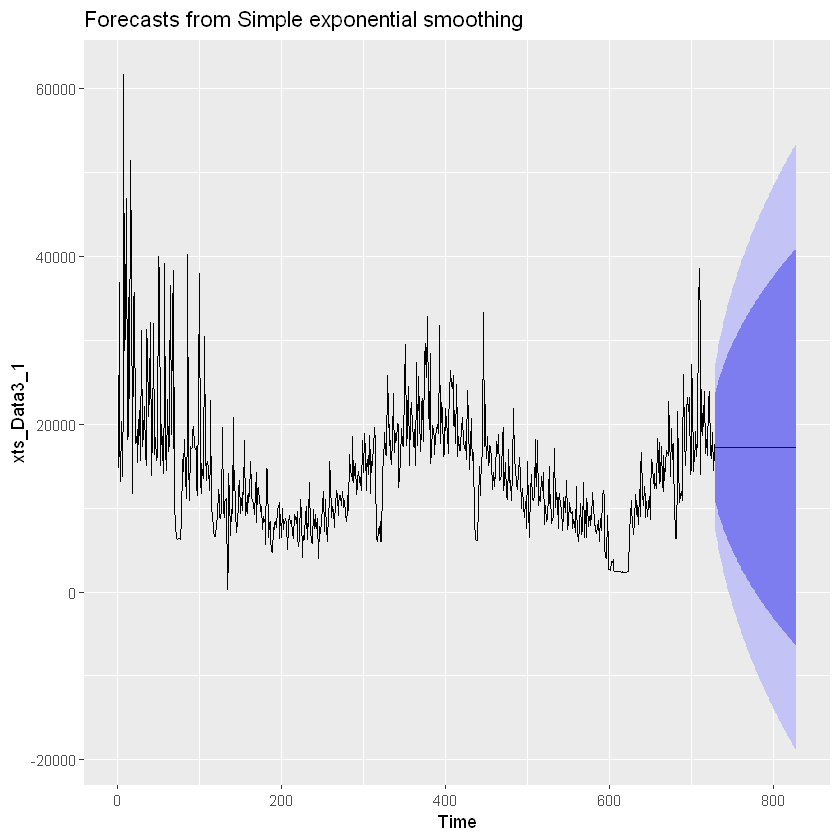

In [7]:
library(xts)
library(forecast)
library(lubridate) 

data1_1 <- data1[rowSums(is.na(data1)) == 0,]
data3_1 <- data1_1 %>% group_by(Date) %>% summarise(daily_active_energy = sum(active_energy))
data3_1$Date <- parse_date_time(data3_1$Date, c('%d%m%y', '%d%m%Y'))
xts_Data3_1 <- xts(data3_1[, -1], order.by=as.Date(data3_1$Date)) #converting to xts 
forecast3b1_1 <- ses(xts_Data3_1, alpha = 0.35, h=100) #fit ses() model
autoplot(forecast3b1_1)

**Calculate tracking signals for three values of alpha value of (0.05, 0.35, 0.75) and h of 100**

In [8]:
a <- c(0.05, 0.35, 0.75)
TS1 <- c()
for(i in a) {
  a1 <-  ses(xts_Data3_1, alpha = i, h=100)
  actual1 <- as.data.frame(xts_Data3_1$daily_active_energy)
  fitted1 <- as.data.frame(a1[['fitted']])
  RSFE1 <- sum(actual1 - fitted1)
  MAD1 <- sum(abs(actual1 - fitted1))/length(actual1$daily_active_energy)
  TS1 <- append(TS1, (RSFE1/MAD1))
}
TS1

[1] -32.0461053  -4.2543312  -0.6789208

**Measuring forecast accuracy by calculating Mean Absolute Deviation (MAD) and Mean Forecast Error (MFE) of the model**

In [9]:
a <- c(0.05, 0.35, 0.75)
MAD <- c()
MFE <- c()
for(i in a) {
  a1 <-  ses(xts_Data3_1, alpha = i, h=100)
  actual1 <- as.data.frame(xts_Data3_1$daily_active_energy)
  fitted1 <- as.data.frame(a1[['fitted']])
  MFE1 <- sum(actual1 - fitted1)/length(actual1$daily_active_energy)
  MAD1 <- sum(abs(actual1 - fitted1))/length(actual1$daily_active_energy)
  MAD <- append(MAD, MAD1)
  MFE <- append(MFE, MFE1)
}
MAD
MFE

[1] 3781.124 3265.847 3401.624

[1] -166.442708  -19.085159   -3.172299

**Evaluation**


The tracking signal for the values of alpha of 0.35 and 0.75 are both within -4 and 4; therefore, the values suggest
these models do not require additional investigation and are good models. 

The MAD values for alphas for 0.35 has the lowest value.
Thereofore, the model using an alpha of 0.35 has less variability. 

The MFE values for all alphas are negative. A negative MFE suggests the model has a tendency to over forcast; however, the model with an MFE closest to zero is considered better, thus MFE for alpha value of 0.75 is closest to zero followed by alpha value of 0.35. 

Looking at the tracking signal, MAD, and MFE, the model using an alpha of 0.35 is a better model. Others might need more investigation. 